**Text Sentiment Analysis**
 -------------------------
 For sentiment analysis we are required to use the sarcasm news dataset. (given an input from the dataset/random input our code should tell if there is sarcasm in it or not.) (two portions in test file. 1 for performance metrics on running on test_set and one for random input from the user to detect sarcasm.)

Author: Muhammad Faizan and syed Farrukh

**The model architecture**

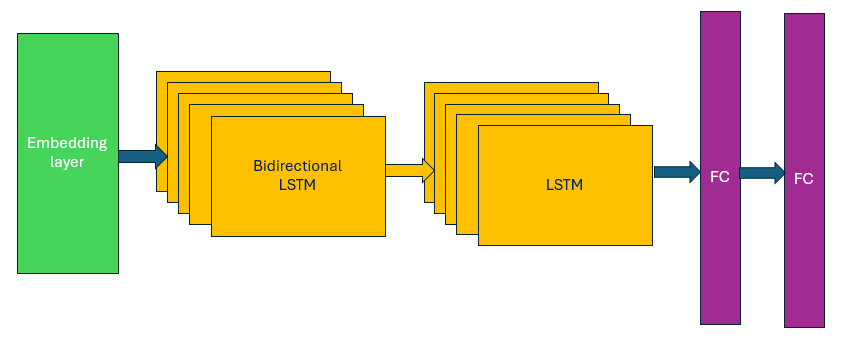

*Department of Robotics & AI - School of Mechanical & Manufacturing Engineering, NUST*

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  %tensorflow_version 2.x
except Exception:
  print("Using TensorFlow 1.x version")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


check if gpu is wroking

In [2]:
!nvidia-smi

Mon Dec 25 10:31:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
%ls

sample_data/


In [4]:
%pwd

'/content'

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Import necessary librararies

In [6]:
# all imports
import json
import tensorflow as tf
import nltk
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
import re
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


**1. Data preprocessing**

- Lower casing
- Removing HTML tags and URLs from the text
- Stop words removal
- Lemmization
- Dataset split
- Tokenization
- Sequence Padding

Loading the dataset

In [7]:
# path to sarcasm dataset path in json format
dataset_path = '/gdrive/MyDrive/DL_mini_project/datasets/sarcasm.json'

if os.path.exists(dataset_path):
  print('the path exists')
else:
  print('Ensure the path is correct.')


the path exists


In [8]:
# read json file and separte the headlines from the labels (sarcasm and non sarcasm)
with open(dataset_path, 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [9]:

print(len(sentences))

26709



**1. Removing tags and URLs from the text**

we need to remove HTML tags, URLs, and non-alphanumeric characters from the reviews. We do that with the help of the remove_tags function, and Regex functions are used for easy string manipulation.

In [10]:
# remove HTML and URL tags from the text if they exists
def remove_tags(string):
    removelist = ""
    result = re.sub('','',string)          #remove HTML tags
    result = re.sub('https://.*','',result)   #remove URLs
    result = result.lower()
    return result
tagsfree_sentences= [remove_tags(sentence) for sentence in sentences]

In [11]:
for i, sent in enumerate(tagsfree_sentences):
  print(sent)
  if i == 5:
    break

former versace store clerk sues over secret 'black code' for minority shoppers
the 'roseanne' revival catches up to our thorny political mood, for better and worse
mom starting to fear son's web series closest thing she will have to grandchild
boehner just wants wife to listen, not come up with alternative debt-reduction ideas
j.k. rowling wishes snape happy birthday in the most magical way
advancing the world's women


**2. Stop Words removal**

Stopwords are commonly used words like ‘and’, ‘the’, ‘at’ that do not add any special meaning or significance to a sentence. A list of stopwords are available with nltk, and they can be removed from the corpus using the following code

In [12]:
# removing stopwords from the text
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stop_words(sentence):
  processed = []
  for word in sentence.split():
    if word not in stop_words:
      processed.append(word)
  return ' '.join(processed)


processed_stopwords_tags_sentences = [remove_stop_words(sentence) for sentence in tagsfree_sentences]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**3. Lemmatization**

 Lemmatization is a useful technique in NLP to obtain the root form of words, known as lemmas. For example, the lemma of the words reading, reads, read is read. This helps save unnecessary computational overhead in trying to decipher entire words, as the meanings of most words are well-expressed by their separate lemmas. We perform lemmatization using the WordNetLemmatizer() from nltk. The text is first broken into individual words using the WhitespaceTokenizer() from nltk. We write a function lemmatize_text to perform lemmatization on the individual tokens.

In [13]:
# perform lemmizataion
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
lemmizated_and_processed_sents = [lemmatize_text(sent) for sent in processed_stopwords_tags_sentences]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
# print some statistics about the data
z = 0.0
for i in lemmizated_and_processed_sents:
    word_list = i.split()
    z =  z + len(word_list)
print("Average length of each review : ",z/len(lemmizated_and_processed_sents))

Average length of each review :  7.148376951589352


In [15]:
pos = 0
for i in range(len(lemmizated_and_processed_sents)):
    if labels[i] == 1:
        pos = pos + 1
neg = len(lemmizated_and_processed_sents)-pos
print("Percentage of reviews with positive sentiment is "+str(pos/len(lemmizated_and_processed_sents)*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/len(lemmizated_and_processed_sents)*100)+"%")

Percentage of reviews with positive sentiment is 43.89531618555543%
Percentage of reviews with negative sentiment is 56.10468381444457%


**4. splitting the dataset**

split the dataset into training and testing with 80% and 20% ratio for each train and test respectively

In [17]:
# hyperparameters
#-----------------
vocab_size = 10000
embedding_dim = 100
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 0.7
validation_size = 0.15
test_size = 0.15

randomly shuffle the dataset and then split it into train, test, and validation

In [18]:
import random

combined_data = list(zip(lemmizated_and_processed_sents, labels))

random.shuffle(combined_data)

lemmizated_and_processed_sents, labels = zip(*combined_data)
lemmizated_and_processed_sents, labels = list(lemmizated_and_processed_sents), list(labels)

In [22]:
lemmizated_and_processed_sents[:5]

['painter search interconnected vision humanity ',
 'real-life nancy drew trace source hpv ',
 "jane fonda time megyn kelly's question plastic surgery ",
 'emperor penguin demand smelt ',
 "8th person donald trump jr.'s meeting russian "]

In [23]:

# split into training and teseting sets
training_length = int(len(labels) * training_size)
validation_length = int(training_length + len(labels) * validation_size)
training_sentences = lemmizated_and_processed_sents[0:training_length]
validation_sentences = lemmizated_and_processed_sents[training_length:validation_length]
test_sentences = lemmizated_and_processed_sents[validation_length:]

training_labels = labels[0:training_length]
validation_labels = labels[training_length:validation_length]
test_labels = labels[validation_length:]

In [24]:
print(f'all dataset size: {len(lemmizated_and_processed_sents)}')
print(f'training set size: {len(training_sentences)}')
print(f'validation set size: {len(validation_sentences)}')
print(f'test set size: {len(test_sentences)}')

all dataset size: 26709
training set size: 18696
validation set size: 4006
test set size: 4007


**Tokenization**

tokenize the text and pad the sequence to have a uniform length

In [26]:
# tokenize the sentences such as headlines into words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(lemmizated_and_processed_sents)

# words to integers mapping dict
word_index = tokenizer.word_index

# Training: Encode the text into numbers and pad the sequence with the maximum length in the sequence, truncate any longer sentence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Testing: Encode the text into numbers and pad the sequence with the maximum length in the sequence, truncate any longer sentence
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [27]:
# get sense what is going on in the dataset
index = 100
print(f'orginal sentence: {training_sentences[index]}')
print(f'Is sarcastic: {training_labels[index]}')
print(f'Encoded sequence: {training_sequences[index]}')
print(f'Padded sequence: {training_padded[index]}')

orginal sentence: report: album good 'sgt. pepper' come every month 
Is sarcastic: 1
Encoded sequence: [9, 828, 75, 9740, 9741, 104, 87, 156]
Padded sequence: [   9  828   75 9740 9741  104   87  156    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0

In [28]:
# convert the TensorFlow tensors to numpy arrays
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)
test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [30]:
save_test_set = True
if save_test_set:
  np.savez('test_set_processed.npz', test_padded= test_padded, test_labels= test_labels)


**Define models**

1. Simple MLP
2. LSTM and MLP based hybrid model




In [31]:
# defining custom loss fuction to increase regularization effect
# to minimize
def regularization_term(true, prediction):
    order = list(range(1,4))
    order.append(0)
    order = tf.constant(order, dtype=tf.float32)

    deviation = (true*true[:,order]) - (prediction*prediction[:,order])
    deviation = abs(deviation)**2
    return 0.2 * deviation

def my_custom_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + regularization_term(y_true, y_pred)


In [32]:
# define the model using Simple MLP
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.03)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#model_mlp.compile(optimizer='Adam', loss=my_custom_loss, metrics = ['accuracy'])
model_mlp.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
model_mlp.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1000000   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                        

In [35]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1087601 (4.15 MB)
Trainable params: 1087601 (4.15 MB)
Non-trainable params: 0 (0.00 Byte)
________________

**Training**

train the given model for num_epochs and using the proprocessed text data along with the given label, train it on training data and validate on validation data

In [36]:
# train the model on the dataset with 3o epochs and validate on the validation dataset
num_epochs = 30
history = model_mlp.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
585/585 - 19s - loss: 0.6847 - accuracy: 0.5628 - val_loss: 0.6742 - val_accuracy: 0.5607 - 19s/epoch - 32ms/step
Epoch 2/30
585/585 - 3s - loss: 0.5351 - accuracy: 0.7323 - val_loss: 0.4611 - val_accuracy: 0.7763 - 3s/epoch - 6ms/step
Epoch 3/30
585/585 - 5s - loss: 0.3707 - accuracy: 0.8420 - val_loss: 0.5135 - val_accuracy: 0.7696 - 5s/epoch - 8ms/step
Epoch 4/30
585/585 - 7s - loss: 0.3118 - accuracy: 0.8751 - val_loss: 0.4542 - val_accuracy: 0.7953 - 7s/epoch - 11ms/step
Epoch 5/30
585/585 - 3s - loss: 0.2757 - accuracy: 0.8912 - val_loss: 0.4749 - val_accuracy: 0.7941 - 3s/epoch - 5ms/step
Epoch 6/30
585/585 - 3s - loss: 0.2477 - accuracy: 0.9046 - val_loss: 0.5510 - val_accuracy: 0.7798 - 3s/epoch - 5ms/step
Epoch 7/30
585/585 - 3s - loss: 0.2269 - accuracy: 0.9104 - val_loss: 0.5207 - val_accuracy: 0.7918 - 3s/epoch - 5ms/step
Epoch 8/30
585/585 - 3s - loss: 0.2073 - accuracy: 0.9188 - val_loss: 0.6521 - val_accuracy: 0.7906 - 3s/epoch - 6ms/step
Epoch 9/30
585/585 -

In [46]:
# train the model on the dataset with 3o epochs and validate on the validation dataset
num_epochs = 30
history = model_lstm.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
585/585 - 21s - loss: 0.5058 - accuracy: 0.7464 - val_loss: 0.4192 - val_accuracy: 0.8068 - 21s/epoch - 36ms/step
Epoch 2/30
585/585 - 11s - loss: 0.2837 - accuracy: 0.8831 - val_loss: 0.4320 - val_accuracy: 0.8000 - 11s/epoch - 18ms/step
Epoch 3/30
585/585 - 10s - loss: 0.1795 - accuracy: 0.9291 - val_loss: 0.5425 - val_accuracy: 0.7973 - 10s/epoch - 16ms/step
Epoch 4/30
585/585 - 12s - loss: 0.1139 - accuracy: 0.9567 - val_loss: 0.6943 - val_accuracy: 0.7861 - 12s/epoch - 21ms/step
Epoch 5/30
585/585 - 11s - loss: 0.0717 - accuracy: 0.9730 - val_loss: 0.9127 - val_accuracy: 0.7791 - 11s/epoch - 18ms/step
Epoch 6/30
585/585 - 10s - loss: 0.0561 - accuracy: 0.9784 - val_loss: 1.1647 - val_accuracy: 0.7796 - 10s/epoch - 17ms/step
Epoch 7/30
585/585 - 11s - loss: 0.0317 - accuracy: 0.9879 - val_loss: 1.3376 - val_accuracy: 0.7798 - 11s/epoch - 18ms/step
Epoch 8/30
585/585 - 10s - loss: 0.0242 - accuracy: 0.9913 - val_loss: 1.5065 - val_accuracy: 0.7776 - 10s/epoch - 17ms/step


**Plotting**

In [37]:
# save model weights
model_mlp.save_weights('model_mlp_weights.h5')

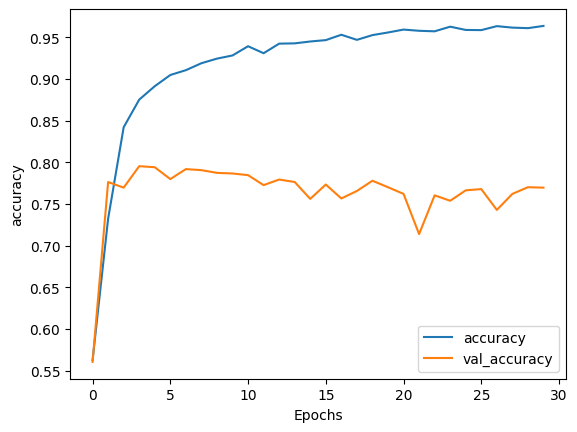

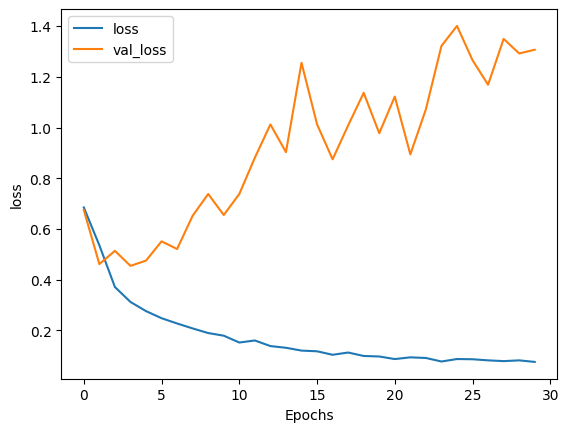

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

save the model architecture in json file for test set evaluation

In [39]:
import json
model_json = model_mlp.to_json()

# Save the model architecture to a JSON file
with open('model_mlp_architecture.json', 'w') as json_file:
    json_file.write(model_json)

In [40]:
# intergers to word mapping for decoding the text
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(labels[0])

painter search <OOV> vision humanity ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
painter search interconnected vision humanity 
0


In [41]:
e = model_mlp.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 100)


In [43]:
# SAVE THE WEIGHTS

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size):
  # word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  # out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

save embeddigns


In [44]:
# DOWNLAOD trained
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

predict on set of setences

In [45]:
pred_threshold = 0.5 # vary it to see the impact for better performance
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night",
             "The weather is getting cold", "The quick brown fox jumps over the lazy dog"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model_mlp.predict(padded).squeeze()

for ind, prediction in enumerate(predictions):
  if float(prediction)>= pred_threshold:
    print(f" {ind + 1} Sarcatic")
  else:
    print(f" {ind + 1} Non Sarcastic")






1/1 [==============================] - 0s 94ms/step
 1 Sarcatic
 2 Non Sarcastic
 3 Non Sarcastic
 4 Sarcatic
